In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
dataset = pd.read_csv('Credit_Card_Applications.csv')

In [ ]:
dataset.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [ ]:
X = dataset.iloc[:,:-1].values

In [ ]:
y= dataset.iloc[:,-1].values

In [ ]:
X.shape, y.shape

((690, 15), (690,))

In [ ]:
#Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X = sc.fit_transform(X)

In [ ]:
# Training SOM
from minisom import MiniSom
# x, y is the grid size of som
# sigma is the radius of the circle which affects a node in som
# through learning rate we adjust weight updation
som = MiniSom(x =10, y=10, input_len=15, sigma=1.0, learning_rate=0.5)

In [ ]:
#initializing random weights for the start
som.random_weights_init(X)

In [ ]:
som.train_random(data=X, num_iteration=100)

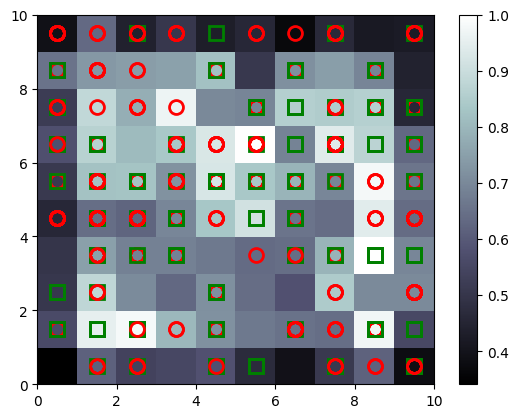

In [ ]:
#visulaizing the results
from pylab import bone , pcolor, colorbar, plot, show
bone()
# distance_map() tells about the winning node for each customer contains the mean inter neuron distances
pcolor(som.distance_map().T)
colorbar()
colors = ['r','g']
markers = ['o','s']
for i, x in enumerate(X):
  w=som.winner(x) #contains the winning node i.e. the node wiht the least distance
  plot(w[0]+0.5,
       w[1]+0.5,
       markers[y[i]],
       markeredgecolor=colors[y[i]],
       markersize=10,
       markerfacecolor='None',
       markeredgewidth =2
       )
show()

In [ ]:
mappings = som.win_map(X)
frauds = np.concatenate((mappings[6,7], mappings[5,4]), axis = 0)
frauds = sc.inverse_transform(frauds)

In [ ]:
customers = dataset.iloc[:, 1:].values
is_fraud = np.zeros(len(dataset))
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)
for i in range(len(dataset)):
  if dataset.iloc[i,0] in frauds:
    is_fraud[i] = 1


In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

model.add(Dense(units = 2, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15))
model.add(Dense(units =1, kernel_initializer = 'uniform', activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.fit(customers, is_fraud, batch_size = 1, epochs = 2)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


690/690 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9728 - loss: 0.5873
Epoch 2/2
690/690 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9835 - loss: 0.1672


In [ ]:
y_pred = model.predict(customers)
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis = 1)
y_pred = y_pred[y_pred[:, 1].argsort()]

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [ ]:
y_pred

array([[1.56214230e+07, 5.53688966e-03],
       [1.56114090e+07, 6.96297502e-03],
       [1.56009750e+07, 7.05041969e-03],
       ...,
       [1.57355720e+07, 1.82821110e-01],
       [1.57163470e+07, 2.37544060e-01],
       [1.58137180e+07, 2.71372139e-01]])

In [ ]:
from collections import defaultdict


In [ ]:

# Map data points to their BMUs
bmu_to_labels = defaultdict(list)
for i, data_point in enumerate(X):
    bmu = som.winner(data_point)  # Find BMU for each data point
    bmu_to_labels[bmu].append(y[i])

# Assign majority label to each neuron
neuron_labels = {}
for bmu, labels in bmu_to_labels.items():
    neuron_labels[bmu] = max(set(labels), key=labels.count)

In [ ]:
# Predict labels based on BMU assignments
predicted_labels = []
for data_point in X:
    bmu = som.winner(data_point)
    predicted_labels.append(neuron_labels[bmu])


In [ ]:
from sklearn.metrics import f1_score

In [ ]:
# Calculate F1 Score
f1 = f1_score(y, predicted_labels, average='weighted')  # Use 'weighted' for multi-class
print(f"F1 Score: {f1:.2f}")


F1 Score: 0.87
